In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('../trackers_stubs/ball_detections.pkl', 'rb') as f:
    ball_detections = pickle.load(f)

In [4]:
ball_detections = [x.get(1,[]) for x in ball_detections]
df_ball_detections = pd.DataFrame(ball_detections, columns=["x1", "y1", "x2", "y2"])

# interpolate
df_ball_detections = df_ball_detections.interpolate()
df_ball_detections = df_ball_detections.bfill()

In [6]:
df_ball_detections['mid_y'] = (df_ball_detections['y1']+df_ball_detections['y2'])/2
df_ball_detections['mid_y_rolling_mean'] = df_ball_detections['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

In [7]:
df_ball_detections.head()

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean
0,892.046875,615.344849,912.306763,637.137695,626.241272,626.241272
1,892.046875,615.344849,912.306763,637.137695,626.241272,626.241272
2,876.760284,631.000061,896.455475,653.131561,642.065811,631.516118
3,861.473694,646.655273,880.604187,669.125427,657.890350,638.109676
4,849.516113,658.243561,867.560883,679.085358,668.664459,644.220633


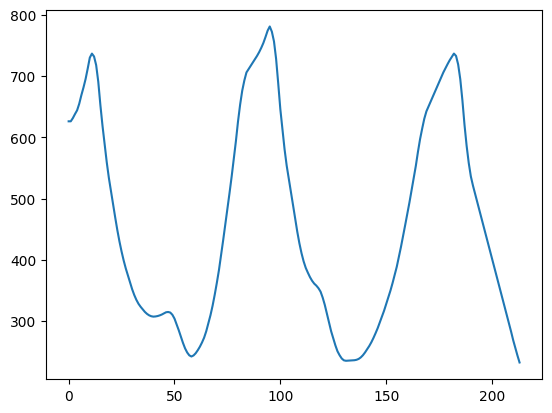

In [8]:
plt.plot(df_ball_detections['mid_y_rolling_mean'])

In [9]:
df_ball_detections['delta_y'] = df_ball_detections['mid_y_rolling_mean'].diff()

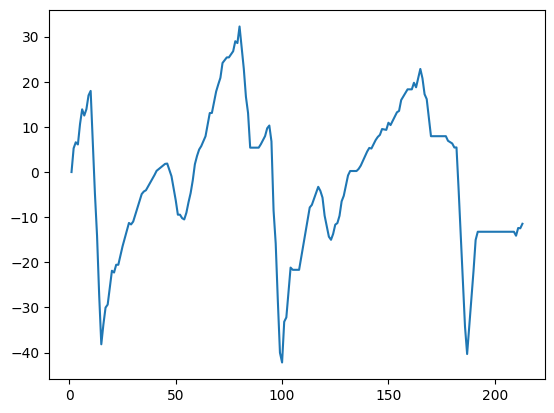

In [10]:
plt.plot(df_ball_detections['delta_y'])

In [11]:
df_ball_detections['hits'] = 0

min_frames_for_hit = 25
for i in range(1, len(df_ball_detections)-int(min_frames_for_hit*1.2)):
    neg_change = df_ball_detections['delta_y'].iloc[i] > 0 and df_ball_detections['delta_y'].iloc[i+1] <0
    pos_change = df_ball_detections['delta_y'].iloc[i] < 0 and df_ball_detections['delta_y'].iloc[i+1] >0

    if neg_change or pos_change:
        change_count = 0
        for change_frame in range(i+1, i+int(min_frames_for_hit*1.2)+1):
            neg_change_nxt_frame = df_ball_detections['delta_y'].iloc[i] > 0 and df_ball_detections['delta_y'].iloc[change_frame] <0
            pos_change_nxt_frame = df_ball_detections['delta_y'].iloc[i] < 0 and df_ball_detections['delta_y'].iloc[change_frame] >0

            if neg_change and neg_change_nxt_frame:
                change_count += 1
            elif pos_change and pos_change_nxt_frame:
                change_count +=1
        
        if change_count>min_frames_for_hit-1:
            df_ball_detections['hits'].iloc[i]= 1

C:\Users\philj\AppData\Local\Temp\ipykernel_26904\63805654.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_detections['hits'].iloc[i]= 1
C:\Users\philj\AppData\Local\Temp\ipykernel_26904\63805654.py:20: SettingWithCopyWarning: 


In [12]:
df_ball_detections[df_ball_detections['hits']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,hits
11,778.387634,718.268921,796.629700,738.953247,728.611084,736.726538,6.578638,1
58,925.402258,241.150467,938.610461,254.343069,247.746768,242.468224,-1.860728,1
95,616.460449,774.642578,638.425781,799.258545,786.950562,780.996393,6.794141,1
131,717.345734,229.868919,728.436432,242.008858,235.938889,235.479034,-0.752928,1
182,1296.774536,740.252563,1313.345215,758.139771,749.196167,736.808487,5.454840,1


In [13]:
frames_hits = df_ball_detections[df_ball_detections['hits']==1].index.tolist()